In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from tqdm import tqdm
import random
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from PIL import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, f1_score, roc_auc_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti


In [3]:
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

DATA_ROOT = "../../data/images/images/" 
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR = os.path.join(DATA_ROOT, "validation") 

IMG_SIZE = (227, 227)
BATCH_SIZE = 64

In [4]:
class EmotionDataset(Dataset):
    def __init__(self, data_dir, emotion_classes, transform=None):
        self.data_dir = data_dir
        self.emotion_classes = emotion_classes
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_counts = {}
        
        self._load_data()
    
    def _load_data(self):
        print(f"Loading data from: {self.data_dir}")
        
        for emotion in self.emotion_classes:
            class_path = os.path.join(self.data_dir, emotion)
            if not os.path.exists(class_path):
                print(f"Warning: Directory {class_path} not found!")
                continue
                
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            self.class_counts[emotion] = len(image_files)
            print(f"Found {len(image_files)} images in {emotion} class")
            
            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                self.image_paths.append(img_path)
                self.labels.append(emotion)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label, img_path
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            dummy_image = Image.new('RGB', IMG_SIZE, (128, 128, 128))
            if self.transform:
                dummy_image = self.transform(dummy_image)
            return dummy_image, label, img_path

In [5]:
basic_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

In [6]:
print("=" * 50)
print("LOADING TRAINING DATA")
print("=" * 50)
train_dataset = EmotionDataset(TRAIN_DIR, emotion_classes, transform=basic_transform)

print("\n" + "=" * 50)
print("LOADING TESTING DATA")
print("=" * 50)
test_dataset = EmotionDataset(TEST_DIR, emotion_classes, transform=basic_transform)

LOADING TRAINING DATA
Loading data from: ../../data/images/images/train
Found 7988 images in angry class
Found 983 images in disgust class
Found 9224 images in fear class
Found 16153 images in happy class
Found 11180 images in neutral class
Found 11015 images in sad class
Found 7207 images in surprise class

LOADING TESTING DATA
Loading data from: ../../data/images/images/validation
Found 960 images in angry class
Found 111 images in disgust class
Found 1018 images in fear class
Found 1825 images in happy class
Found 1216 images in neutral class
Found 1139 images in sad class
Found 797 images in surprise class


In [7]:
def analyze_class_distribution(class_counts, dataset_name="Dataset"):
    print(f"\n{dataset_name} Class Distribution:")
    print("-" * 40)
    
    total_samples = sum(class_counts.values())
    sorted_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))
    
    for emotion, count in sorted_counts.items():
        percentage = (count / total_samples) * 100
        print(f"{emotion:>8}: {count:>6} samples ({percentage:>5.1f}%)")
    
    max_samples = max(class_counts.values())
    min_samples = min(class_counts.values())
    imbalance_ratio = max_samples / min_samples
    
    print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
    print(f"Majority class: {max(class_counts.items(), key=lambda x: x[1])}")
    print(f"Minority class: {min(class_counts.items(), key=lambda x: x[1])}")
    
    return sorted_counts, imbalance_ratio


Training Data Class Distribution:
----------------------------------------
   happy:  16153 samples ( 25.3%)
 neutral:  11180 samples ( 17.5%)
     sad:  11015 samples ( 17.3%)
    fear:   9224 samples ( 14.5%)
   angry:   7988 samples ( 12.5%)
surprise:   7207 samples ( 11.3%)
 disgust:    983 samples (  1.5%)

Imbalance Ratio: 16.43
Majority class: ('happy', 16153)
Minority class: ('disgust', 983)

Testing Data Class Distribution:
----------------------------------------
   happy:   1825 samples ( 25.8%)
 neutral:   1216 samples ( 17.2%)
     sad:   1139 samples ( 16.1%)
    fear:   1018 samples ( 14.4%)
   angry:    960 samples ( 13.6%)
surprise:    797 samples ( 11.3%)
 disgust:    111 samples (  1.6%)

Imbalance Ratio: 16.44
Majority class: ('happy', 1825)
Minority class: ('disgust', 111)


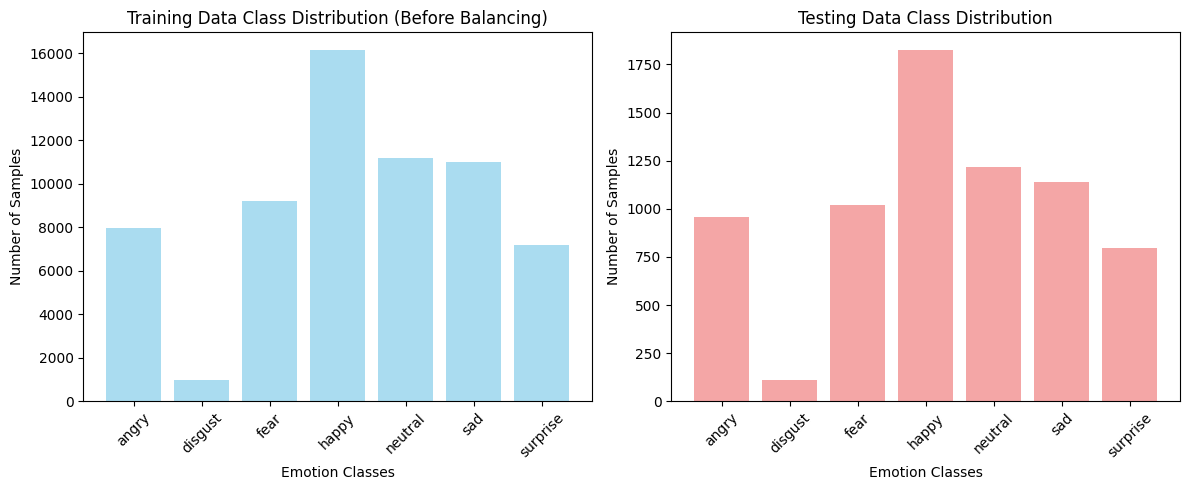

In [8]:
train_distribution, train_imbalance_ratio = analyze_class_distribution(
    train_dataset.class_counts, "Training Data"
)

test_distribution, test_imbalance_ratio = analyze_class_distribution(
    test_dataset.class_counts, "Testing Data"
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
emotions = list(train_dataset.class_counts.keys())
counts = list(train_dataset.class_counts.values())
plt.bar(emotions, counts, color='skyblue', alpha=0.7)
plt.title('Training Data Class Distribution (Before Balancing)')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
emotions = list(test_dataset.class_counts.keys())
counts = list(test_dataset.class_counts.values())
plt.bar(emotions, counts, color='lightcoral', alpha=0.7)
plt.title('Testing Data Class Distribution')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [9]:
class RandomAdjustSharpness:
 
    def __init__(self, factor=2.0):
        self.factor = factor
    
    def __call__(self, img):
        from PIL import ImageEnhance
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(self.factor)

In [10]:
augmentation_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(degrees=90),  
    RandomAdjustSharpness(factor=2.0),      
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.ToTensor(),
])

inception_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])  
])

In [11]:
class BalancedEmotionDataset(Dataset):
    def __init__(self, original_dataset, target_samples_per_class=None):
        self.original_dataset = original_dataset
        self.emotion_classes = original_dataset.emotion_classes
        self.original_distribution = Counter(original_dataset.labels)
        if target_samples_per_class is None:
            self.target_samples_per_class = max(self.original_distribution.values())
        else:
            self.target_samples_per_class = target_samples_per_class
            
        self._create_balanced_indices()
        
    def _create_balanced_indices(self):
        print(f"\nBalancing dataset to {self.target_samples_per_class} samples per class...")
        
        class_indices = {emotion: [] for emotion in self.emotion_classes}
        
        for idx, label in enumerate(self.original_dataset.labels):
            class_indices[label].append(idx)
        
        self.balanced_indices = []
        self.balanced_labels = []
        self.augmentation_flags = [] 
        
        for emotion in self.emotion_classes:
            original_indices = class_indices[emotion]
            current_count = len(original_indices)
            print(f"  {emotion}: {current_count} -> {self.target_samples_per_class}")
            self.balanced_indices.extend(original_indices)
            self.balanced_labels.extend([emotion] * current_count)
            self.augmentation_flags.extend([False] * current_count)  
            
            if current_count < self.target_samples_per_class:
                needed = self.target_samples_per_class - current_count
                
                additional_indices = np.random.choice(original_indices, needed, replace=True)
                
                self.balanced_indices.extend(additional_indices.tolist())
                self.balanced_labels.extend([emotion] * needed)
                self.augmentation_flags.extend([True] * needed)  
        
        print(f"Balanced dataset size: {len(self.balanced_indices)}")
        
        combined = list(zip(self.balanced_indices, self.balanced_labels, self.augmentation_flags))
        np.random.shuffle(combined)
        self.balanced_indices, self.balanced_labels, self.augmentation_flags = zip(*combined)
    
    def __len__(self):
        return len(self.balanced_indices)
    
    def __getitem__(self, idx):
        original_idx = self.balanced_indices[idx]
        label = self.balanced_labels[idx]
        need_augmentation = self.augmentation_flags[idx]
        img_path = self.original_dataset.image_paths[original_idx]
        try:
            image = Image.open(img_path).convert('RGB')
            
            if need_augmentation:
                image = augmentation_transform(image)
            else:
                image = inception_transform(image)
                
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            dummy_image = Image.new('RGB', IMG_SIZE, (128, 128, 128))
            image = inception_transform(dummy_image)
        
        return image, label

In [12]:
balanced_train_dataset = BalancedEmotionDataset(train_dataset)
final_distribution = Counter(balanced_train_dataset.balanced_labels)
print("\nFinal balanced distribution:")

for emotion, count in final_distribution.items():
    print(f"  {emotion}: {count} samples")
train_loader = DataLoader(
    balanced_train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

test_transform = inception_transform

class TestEmotionDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        img_path = self.original_dataset.image_paths[idx]
        label = self.original_dataset.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            dummy_image = Image.new('RGB', IMG_SIZE, (128, 128, 128))
            image = self.transform(dummy_image)
        
        return image, label

test_processed_dataset = TestEmotionDataset(test_dataset, test_transform)
test_loader = DataLoader(
    test_processed_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"Train loader batches: {len(train_loader)}")
print(f"Test loader batches: {len(test_loader)}")



Balancing dataset to 16153 samples per class...
  angry: 7988 -> 16153
  disgust: 983 -> 16153
  fear: 9224 -> 16153
  happy: 16153 -> 16153
  neutral: 11180 -> 16153
  sad: 11015 -> 16153
  surprise: 7207 -> 16153
Balanced dataset size: 113071

Final balanced distribution:
  neutral: 16153 samples
  disgust: 16153 samples
  happy: 16153 samples
  angry: 16153 samples
  surprise: 16153 samples
  sad: 16153 samples
  fear: 16153 samples
Train loader batches: 1767
Test loader batches: 111


In [13]:
class InceptionV3FeatureExtractor(nn.Module):
    def __init__(self):
        super(InceptionV3FeatureExtractor, self).__init__()
        self.inception = inception_v3(pretrained=True, aux_logits=True)  
        self.inception.fc = nn.Identity()
        
        for param in self.parameters():
            param.requires_grad = False
        
        self.eval()

    def forward(self, x):
        output = self.inception(x)
        if isinstance(output, tuple):
            return output[0]
        return output

In [14]:
print("\n" + "=" * 50)
print("CREATING INCEPTIONV3 FEATURE EXTRACTOR")
print("=" * 50)

feature_extractor = InceptionV3FeatureExtractor().to(device)
print(f"InceptionV3 feature extractor created and moved to {device}")

with torch.no_grad():
    test_batch = torch.randn(2, 3, IMG_SIZE[0], IMG_SIZE[1]).to(device)
    test_features = feature_extractor(test_batch)
    print(f"Feature shape: {test_features.shape}")
    feature_dim = test_features.shape[1]

print(f"Feature dimension: {feature_dim}")


CREATING INCEPTIONV3 FEATURE EXTRACTOR
InceptionV3 feature extractor created and moved to cuda
Feature shape: torch.Size([2, 2048])
Feature dimension: 2048


In [15]:
def extract_features_from_loader(model, dataloader, device):
    model.eval()
    all_features = []
    all_labels = []
    
    print(f"Processing {len(dataloader)} batches...")
    
    with torch.no_grad():
        try:
            dataloader_iter = iter(dataloader)
            for batch_idx in tqdm(range(len(dataloader)), desc= "extracting"):
                batch = next(dataloader_iter)

                if len(batch) ==2:
                    images, labels = batch
                else:
                    images, labels = batch[0], batch[1]
                
                images = images.to(device)
                features = model(images)

                all_features.append(features.cpu().numpy())
                all_labels.extend(labels)

                if (batch_idx + 1) % 50 == 0:
                    print(f"processed {batch_idx + 1} batches successfully")
        
        except Exception as e:
            print(f"error at batch {batch_idx}: {e}")
            if len(all_features) > 0:
                print("returning partial results")
            else:
                raise e
    
    return np.vstack(all_features), np.array(all_labels)
 

In [16]:
print("\n" + "=" * 50)
print("EXTRACTING FEATURES - TRAINING DATA")
print("=" * 50)

print(f"Train loader length: {len(train_loader)}")
print(f"Feature extractor device: {next(feature_extractor.parameters()).device}")
print(f"Target device: {device}")

X_train_features, y_train_labels = extract_features_from_loader(
    feature_extractor, train_loader, device
)

print("\n" + "=" * 50)
print("EXTRACTING FEATURES - TESTING DATA")
print("=" * 50)

print(f"Test loader length: {len(test_loader)}")
X_test_features, y_test_labels = extract_features_from_loader(
    feature_extractor, test_loader, device
)

print(f"\nFeature extraction completed!")
print(f"Training features shape: {X_train_features.shape}")
print(f"Testing features shape: {X_test_features.shape}")
print(f"Training labels shape: {y_train_labels.shape}")
print(f"Testing labels shape: {y_test_labels.shape}")


EXTRACTING FEATURES - TRAINING DATA
Train loader length: 1767
Feature extractor device: cuda:0
Target device: cuda
Processing 1767 batches...


extracting:   3%|▎         | 51/1767 [00:09<05:51,  4.88it/s]

processed 50 batches successfully


extracting:   6%|▌         | 101/1767 [00:19<06:08,  4.52it/s]

processed 100 batches successfully


extracting:   8%|▊         | 150/1767 [00:30<05:46,  4.67it/s]

processed 150 batches successfully


extracting:  11%|█▏        | 201/1767 [00:41<05:15,  4.96it/s]

processed 200 batches successfully


extracting:  14%|█▍        | 251/1767 [00:51<05:29,  4.60it/s]

processed 250 batches successfully


extracting:  17%|█▋        | 300/1767 [01:02<05:27,  4.47it/s]

processed 300 batches successfully


extracting:  20%|█▉        | 351/1767 [01:13<04:59,  4.74it/s]

processed 350 batches successfully


extracting:  23%|██▎       | 400/1767 [01:24<04:53,  4.66it/s]

processed 400 batches successfully


extracting:  25%|██▌       | 450/1767 [01:35<04:53,  4.49it/s]

processed 450 batches successfully


extracting:  28%|██▊       | 500/1767 [01:46<04:33,  4.63it/s]

processed 500 batches successfully


extracting:  31%|███       | 551/1767 [01:57<04:20,  4.66it/s]

processed 550 batches successfully


extracting:  34%|███▍      | 600/1767 [02:08<04:04,  4.78it/s]

processed 600 batches successfully


extracting:  37%|███▋      | 650/1767 [02:19<04:05,  4.54it/s]

processed 650 batches successfully


extracting:  40%|███▉      | 700/1767 [02:29<03:51,  4.61it/s]

processed 700 batches successfully


extracting:  42%|████▏     | 750/1767 [02:40<03:38,  4.65it/s]

processed 750 batches successfully


extracting:  45%|████▌     | 800/1767 [02:51<03:26,  4.68it/s]

processed 800 batches successfully


extracting:  48%|████▊     | 851/1767 [03:02<03:12,  4.75it/s]

processed 850 batches successfully


extracting:  51%|█████     | 900/1767 [03:13<03:06,  4.65it/s]

processed 900 batches successfully


extracting:  54%|█████▍    | 950/1767 [03:24<03:00,  4.51it/s]

processed 950 batches successfully


extracting:  57%|█████▋    | 1000/1767 [03:35<02:48,  4.55it/s]

processed 1000 batches successfully


extracting:  59%|█████▉    | 1050/1767 [03:46<02:31,  4.72it/s]

processed 1050 batches successfully


extracting:  62%|██████▏   | 1100/1767 [03:57<02:23,  4.64it/s]

processed 1100 batches successfully


extracting:  65%|██████▌   | 1151/1767 [04:08<02:12,  4.64it/s]

processed 1150 batches successfully


extracting:  68%|██████▊   | 1200/1767 [04:18<02:01,  4.66it/s]

processed 1200 batches successfully


extracting:  71%|███████   | 1250/1767 [04:29<02:01,  4.24it/s]

processed 1250 batches successfully


extracting:  74%|███████▎  | 1300/1767 [04:40<01:40,  4.64it/s]

processed 1300 batches successfully


extracting:  76%|███████▋  | 1350/1767 [04:51<01:33,  4.47it/s]

processed 1350 batches successfully


extracting:  79%|███████▉  | 1401/1767 [05:03<01:18,  4.66it/s]

processed 1400 batches successfully


extracting:  82%|████████▏ | 1450/1767 [05:14<01:12,  4.34it/s]

processed 1450 batches successfully


extracting:  85%|████████▍ | 1500/1767 [05:25<00:55,  4.85it/s]

processed 1500 batches successfully


extracting:  88%|████████▊ | 1551/1767 [05:36<00:46,  4.64it/s]

processed 1550 batches successfully


extracting:  91%|█████████ | 1600/1767 [05:46<00:35,  4.65it/s]

processed 1600 batches successfully


extracting:  93%|█████████▎| 1650/1767 [05:57<00:24,  4.69it/s]

processed 1650 batches successfully


extracting:  96%|█████████▌| 1700/1767 [06:08<00:14,  4.62it/s]

processed 1700 batches successfully


extracting:  99%|█████████▉| 1750/1767 [06:19<00:03,  4.53it/s]

processed 1750 batches successfully


extracting: 100%|██████████| 1767/1767 [06:22<00:00,  4.61it/s]



EXTRACTING FEATURES - TESTING DATA
Test loader length: 111
Processing 111 batches...


extracting:  46%|████▌     | 51/111 [00:06<00:07,  8.15it/s]

processed 50 batches successfully


extracting:  91%|█████████ | 101/111 [00:12<00:01,  9.33it/s]

processed 100 batches successfully


extracting: 100%|██████████| 111/111 [00:13<00:00,  8.44it/s]


Feature extraction completed!
Training features shape: (113071, 2048)
Testing features shape: (7066, 2048)
Training labels shape: (113071,)
Testing labels shape: (7066,)


In [17]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_test_encoded = label_encoder.transform(y_test_labels)

print(f"\nLabel encoding:")
print(f"Classes: {label_encoder.classes_}")
print(f"Encoded training labels shape: {y_train_encoded.shape}")
print(f"Encoded testing labels shape: {y_test_encoded.shape}")


Label encoding:
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Encoded training labels shape: (113071,)
Encoded testing labels shape: (7066,)


In [18]:
print("\n" + "=" * 50)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("=" * 50)

rf_classifier = RandomForestClassifier(
    n_estimators=200,          
    max_depth=25,              
    min_samples_split=5,       
    min_samples_leaf=2,        
    max_features='sqrt',       
    bootstrap=True,            
    random_state=42,           
    n_jobs=-1,                 
    verbose=1                  
)

print("Training Random Forest...")
print(f"Training on {X_train_features.shape[0]} samples with {X_train_features.shape[1]} features")
rf_classifier.fit(X_train_features, y_train_encoded)
print("Training completed!")



TRAINING RANDOM FOREST CLASSIFIER
Training Random Forest...
Training on 113071 samples with 2048 features


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min


Training completed!


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.6min finished


In [25]:
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

print("Making predictions on test set...")
y_pred = rf_classifier.predict(X_test_features)
y_pred_proba = rf_classifier.predict_proba(X_test_features)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f} ({accuracy*100:.2f}%)")

f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
class_report = classification_report(
    y_test_encoded, y_pred, 
    target_names=emotion_classes,
    digits=4
)
print(class_report)


MODEL EVALUATION
Making predictions on test set...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



Accuracy Score: 0.9768 (97.68%)
F1-Score (Weighted): 0.9762
F1-Score (Macro): 0.9759

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.9964    0.8552    0.9204       960
     disgust     0.9908    0.9730    0.9818       111
        fear     0.9835    0.9951    0.9893      1018
       happy     0.9656    1.0000    0.9825      1825
     neutral     0.9750    0.9951    0.9849      1216
         sad     0.9659    0.9956    0.9805      1139
    surprise     0.9912    0.9925    0.9918       797

    accuracy                         0.9768      7066
   macro avg     0.9812    0.9723    0.9759      7066
weighted avg     0.9773    0.9768    0.9762      7066



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished



CONFUSION MATRIX
Confusion Matrix (Raw Counts):
[[ 821    1   13   51   29   39    6]
 [   0  108    0    3    0    0    0]
 [   0    0 1013    1    2    1    1]
 [   0    0    0 1825    0    0    0]
 [   0    0    0    6 1210    0    0]
 [   3    0    1    1    0 1134    0]
 [   0    0    3    3    0    0  791]]


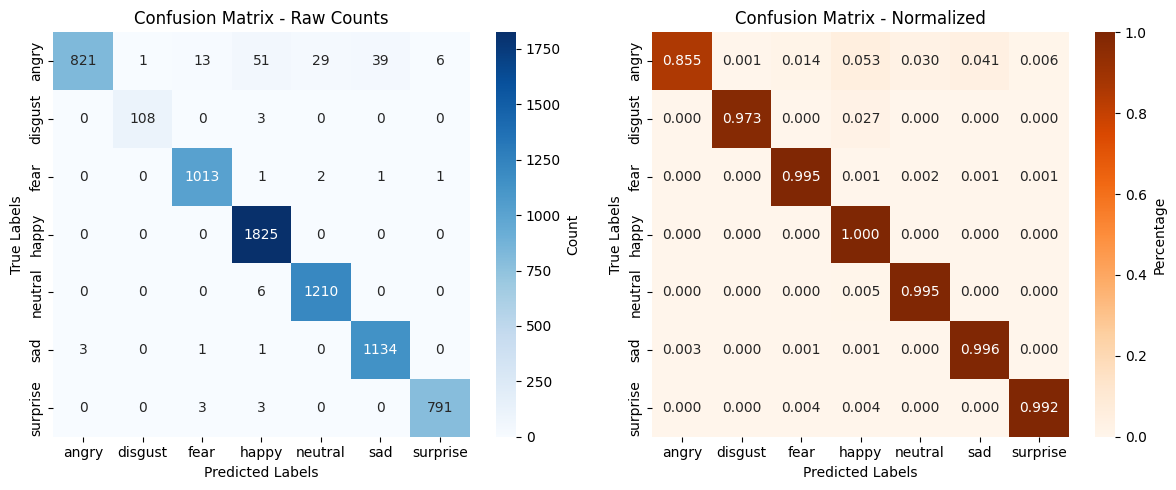

In [26]:
print("\n" + "=" * 50)
print("CONFUSION MATRIX")
print("=" * 50)

cm = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix (Raw Counts):")
print(cm)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_classes,
            yticklabels=emotion_classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Raw Counts')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

cm_normalized = confusion_matrix(y_test_encoded, y_pred, normalize='true')
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Oranges',
            xticklabels=emotion_classes,
            yticklabels=emotion_classes,
            cbar_kws={'label': 'Percentage'})
plt.title('Confusion Matrix - Normalized')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

In [27]:
print("\n" + "=" * 50)
print("ROC AUC ANALYSIS")
print("=" * 50)

try:
    roc_auc_ovr = roc_auc_score(y_test_encoded, y_pred_proba, 
                               multi_class='ovr', average='weighted')
    roc_auc_ovo = roc_auc_score(y_test_encoded, y_pred_proba, 
                               multi_class='ovo', average='weighted')
    
    print(f"ROC AUC Score (One-vs-Rest): {roc_auc_ovr:.4f}")
    print(f"ROC AUC Score (One-vs-One): {roc_auc_ovo:.4f}")
    
    print("\nROC AUC per class (One-vs-Rest):")
    roc_auc_per_class = roc_auc_score(y_test_encoded, y_pred_proba, 
                                     multi_class='ovr', average=None)
    for i, emotion in enumerate(emotion_classes):
        print(f"  {emotion:>8}: {roc_auc_per_class[i]:.4f}")

except Exception as e:
    print(f"Error calculating ROC AUC: {e}")


ROC AUC ANALYSIS
ROC AUC Score (One-vs-Rest): 0.9988
ROC AUC Score (One-vs-One): 0.9988

ROC AUC per class (One-vs-Rest):
     angry: 0.9941
   disgust: 0.9999
      fear: 0.9994
     happy: 0.9996
   neutral: 0.9999
       sad: 0.9992
  surprise: 0.9999



FEATURE IMPORTANCE ANALYSIS
Feature importance statistics:
  Mean: 0.000488
  Std:  0.000196
  Max:  0.002797
  Min:  0.000165

Top 10 most important features (indices):
  Feature  129: 0.002797
  Feature  753: 0.002375
  Feature  275: 0.002308
  Feature  118: 0.002135
  Feature  293: 0.002001
  Feature 1056: 0.001958
  Feature 1058: 0.001937
  Feature  232: 0.001908
  Feature 1551: 0.001799
  Feature  942: 0.001677


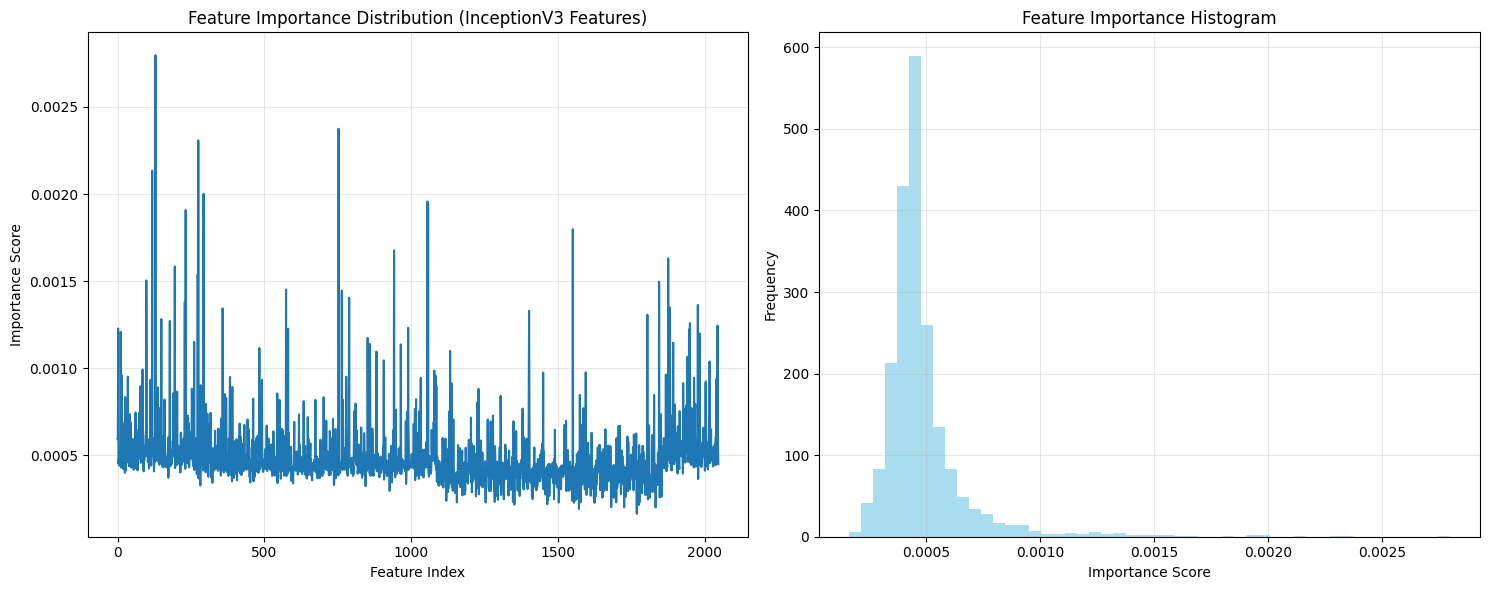

In [28]:
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

feature_importance = rf_classifier.feature_importances_
print(f"Feature importance statistics:")
print(f"  Mean: {np.mean(feature_importance):.6f}")
print(f"  Std:  {np.std(feature_importance):.6f}")
print(f"  Max:  {np.max(feature_importance):.6f}")
print(f"  Min:  {np.min(feature_importance):.6f}")

print(f"\nTop 10 most important features (indices):")
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

for i, idx in enumerate(top_features_idx):
    print(f"  Feature {idx:>4}: {feature_importance[idx]:.6f}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(feature_importance)
plt.title('Feature Importance Distribution (InceptionV3 Features)')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(feature_importance, bins=50, alpha=0.7, color='skyblue')
plt.title('Feature Importance Histogram')
plt.xlabel('Importance Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
def analyze_classification_errors(y_true, y_pred, class_names):
    """
    Analisis kesalahan klasifikasi yang paling umum
    """
    print("\n" + "=" * 50)
    print("CLASSIFICATION ERROR ANALYSIS")
    print("=" * 50)
    
    cm = confusion_matrix(y_true, y_pred)
    
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i][j] > 0: 
                error_rate = cm[i][j] / cm[i].sum()  
                errors.append((class_names[i], class_names[j], cm[i][j], error_rate))
    
    errors.sort(key=lambda x: x[2], reverse=True)
    
    print("Most common classification errors:")
    print("True → Predicted : Count (Error Rate)")
    print("-" * 40)
    for true_class, pred_class, count, error_rate in errors[:10]:
        print(f"{true_class:>8} → {pred_class:<8} : {count:>3} ({error_rate:>6.1%})")
    
    return errors

classification_errors = analyze_classification_errors(
    y_test_encoded, y_pred, emotion_classes
)


CLASSIFICATION ERROR ANALYSIS
Most common classification errors:
True → Predicted : Count (Error Rate)
----------------------------------------
   angry → happy    :  51 (  5.3%)
   angry → sad      :  39 (  4.1%)
   angry → neutral  :  29 (  3.0%)
   angry → fear     :  13 (  1.4%)
   angry → surprise :   6 (  0.6%)
 neutral → happy    :   6 (  0.5%)
 disgust → happy    :   3 (  2.7%)
     sad → angry    :   3 (  0.3%)
surprise → fear     :   3 (  0.4%)
surprise → happy    :   3 (  0.4%)


In [24]:
print("\n" + "=" * 50)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 50)

from sklearn.metrics import precision_score, recall_score, f1_score

precision_per_class = precision_score(y_test_encoded, y_pred, average=None)
recall_per_class = recall_score(y_test_encoded, y_pred, average=None)
f1_per_class = f1_score(y_test_encoded, y_pred, average=None)

print("Per-class metrics:")
print("Class     | Precision | Recall | F1-Score | Support")
print("-" * 50)

for i, emotion in enumerate(emotion_classes):
    support = np.sum(y_test_encoded == i)
    print(f"{emotion:>8} | {precision_per_class[i]:>8.3f} | {recall_per_class[i]:>6.3f} | "
          f"{f1_per_class[i]:>7.3f} | {support:>6}")


PER-CLASS PERFORMANCE ANALYSIS
Per-class metrics:
Class     | Precision | Recall | F1-Score | Support
--------------------------------------------------
   angry |    0.996 |  0.855 |   0.920 |    960
 disgust |    0.991 |  0.973 |   0.982 |    111
    fear |    0.983 |  0.995 |   0.989 |   1018
   happy |    0.966 |  1.000 |   0.983 |   1825
 neutral |    0.975 |  0.995 |   0.985 |   1216
     sad |    0.966 |  0.996 |   0.981 |   1139
surprise |    0.991 |  0.992 |   0.992 |    797
